# Read Me before running

This notebook was developed on CoLab, if you want to run it, please upload folder *data* and this notebook to Google Drive.

In [2]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 43 kB/s 
     |████████████████████████████████| 198 kB 28.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=3244720ded0ac2cc4e44f3835189f6a0ee042a02b8ac623bc32d66e768c6fa27
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


# Extract Comments

In [4]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *
import os

#spark = SparkContext.getOrCreate()
spark = SparkSession.builder.master("local[*]").config("spark.executor.memory", "128g").config("spark.executor.memory", "32g").getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive/Colab\ Notebooks/drive/final



all_comments.csv	    Guardian_videos_final.csv	  NRC.xlsx
BBC_videos_final.csv	    Independent_videos_final.csv  SUN_videos_final.csv
DailyMail_videos_final.csv  NRC.csv


## Load Data

In [6]:
df_comments = spark.read.option("header",True).csv("/content/drive/MyDrive/data/all_comments.csv")
df_comments.show()

+--------------------+--------+----+
|                text|    date|from|
+--------------------+--------+----+
|Think about it th...|20200320| SUN|
|&quot;Advice&quot...|20200320| SUN|
|He sounds like a ...|20200320| SUN|
|CANCEL COUNCIL TA...|20200320| SUN|
|Then please solve...|20200320| SUN|
|There&#39;s more ...|20200320| SUN|
|Within a week we’...|20200320| SUN|
|Over 70s, vulnera...|20200320| SUN|
|It&#39;s selfish ...|20200320| SUN|
|Boris needs to gr...|20200320| SUN|
|This by the way t...|20200320| SUN|
|I have anxiety so...|20200320| SUN|
|Financial aid for...|20200320| SUN|
|Nobody taking thi...|20200320| SUN|
|I’ve just had to ...|20200320| SUN|
|Don’t forget a fe...|20200320| SUN|
|Well force a lock...|20200320| SUN|
|Businesses can&#3...|20200320| SUN|
|Nobody is taking ...|20200320| SUN|
|Take the money fr...|20200320| SUN|
+--------------------+--------+----+
only showing top 20 rows



# Fine-grained Sentiment Analysis

## Load sentiment dictionary

In [10]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/MyDrive/data
lexion_df = pd.read_excel('/content/drive/MyDrive/data/NRC.xlsx')
lexion_df.head()

eng_df = lexion_df[['English Word', 'Positive', 'Negative', 
                 'Anger','Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']]
eng_df.head()

Positive = []
Negative = []
Anger = []
Anticipation = []
Disgust = []
Fear = []
Joy = []
Sadness = []
Surprise = []
Trust = []
for idx, row in eng_df.iterrows():
    if row['Positive']==1:
        Positive.append(row['English Word'])
    if row['Negative']==1:
        Negative.append(row['English Word'])
    if row['Anger']==1:
        Anger.append(row['English Word'])
    if row['Anticipation']==1:
        Anticipation.append(row['English Word'])
    if row['Disgust']==1:
        Disgust.append(row['English Word'])
    if row['Fear']==1:
        Fear.append(row['English Word'])
    if row['Joy']==1:
        Joy.append(row['English Word'])
    if row['Sadness']==1:
        Sadness.append(row['English Word'])
    if row['Surprise']==1:
        Surprise.append(row['English Word'])
    if row['Trust']==1:
        Trust.append(row['English Word'])
  
print('Load word dict finished')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
all_comments.csv  NRC.xlsx
Load word dict finished


## Define Sentiment UDF function

In [11]:
from pyspark.sql.types import FloatType, ArrayType, MapType, StringType, IntegerType
import jieba
import time

def anger_emotion(text):
    anger = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Anger:
            anger+=freq
    return anger

def anticipation_emotion(text):
    anticipation = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Anticipation:
            anticipation+=freq
    return anticipation

def disgust_emotion(text):
    disgust = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Disgust:
            disgust+=freq
    return disgust

def fear_emotion(text):
    fear = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Fear:
            fear+=freq
    return fear

def joy_emotion(text):
    joy = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Joy:
            joy+=freq
    return joy

def sadness_emotion(text):
    sadness = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Sadness:
            sadness+=freq
    return sadness

def surprise_emotion(text):
    surprise = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Surprise:
            surprise+=freq
    return surprise

def trust_emotion(text):
    trust = 0

    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Trust:
            trust+=freq
    return trust

def comment_len(text):
    trust = 0

    wordlist = jieba.lcut(text)
    
    return len(wordlist)

udf_anger_emotion = udf(lambda z: anger_emotion(z), IntegerType())
udf_anticipation_emotion = udf(lambda z: anticipation_emotion(z), IntegerType())
udf_disgust_emotion = udf(lambda z: disgust_emotion(z), IntegerType())
udf_fear_emotion = udf(lambda z: fear_emotion(z), IntegerType())
udf_joy_emotion = udf(lambda z: joy_emotion(z), IntegerType())
udf_sadness_emotion = udf(lambda z: sadness_emotion(z), IntegerType())
udf_surprise_emotion = udf(lambda z: surprise_emotion(z), IntegerType())
udf_trust_emotion = udf(lambda z: trust_emotion(z), IntegerType())
udf_comment_len = udf(lambda z: comment_len(z), IntegerType())


df_udf = df_comments.withColumn("anger", udf_anger_emotion(df_comments.text))
df_udf = df_udf.withColumn("anticipation", udf_anticipation_emotion(df_udf.text))
df_udf = df_udf.withColumn("disgust", udf_disgust_emotion(df_udf.text))
df_udf = df_udf.withColumn("fear", udf_fear_emotion(df_udf.text))
df_udf = df_udf.withColumn("joy", udf_joy_emotion(df_udf.text))
df_udf = df_udf.withColumn("sadness", udf_sadness_emotion(df_udf.text))
df_udf = df_udf.withColumn("surprise", udf_surprise_emotion(df_udf.text))
df_udf = df_udf.withColumn("trust", udf_trust_emotion(df_udf.text))
df_udf = df_udf.withColumn("length", udf_comment_len(df_udf.text))

df_udf.show()

+--------------------+--------+----+-----+------------+-------+----+---+-------+--------+-----+------+
|                text|    date|from|anger|anticipation|disgust|fear|joy|sadness|surprise|trust|length|
+--------------------+--------+----+-----+------------+-------+----+---+-------+--------+-----+------+
|Think about it th...|20200320| SUN|    2|           1|      0|   4|  0|      1|       0|    3|    84|
|&quot;Advice&quot...|20200320| SUN|    0|           0|      0|   0|  0|      0|       0|    1|    62|
|He sounds like a ...|20200320| SUN|    1|           0|      2|   3|  0|      1|       0|    1|    83|
|CANCEL COUNCIL TA...|20200320| SUN|    0|           0|      0|   0|  0|      0|       0|    0|    13|
|Then please solve...|20200320| SUN|    0|           1|      0|   0|  1|      0|       0|    1|    75|
|There&#39;s more ...|20200320| SUN|    0|           0|      0|   0|  0|      0|       0|    0|    27|
|Within a week we’...|20200320| SUN|    0|           0|      0|   0|  0| 

## Get Sentiment for each media 
group by half month and  sort by date

In [12]:
from datetime import datetime, timedelta
import time
#BBC_comments = df_udf.filter(df_udf['from'] == 'BBC') \
#                      .select("date","from","anger","anticipation","disgust","fear","joy","sadness","surprise","trust")
                      
all_data = df_udf.groupBy('date','from') \
                            .agg({"anger":"sum","anticipation":"sum","disgust":"sum","fear":"sum","joy":"sum","sadness":"sum","surprise":"sum","trust":"sum"}) \
                            .withColumnRenamed("sum(anger)", "anger") \
                            .withColumnRenamed("sum(anticipation)", "anticipation") \
                            .withColumnRenamed("sum(disgust)", "disgust") \
                            .withColumnRenamed("sum(fear)", "fear") \
                            .withColumnRenamed("sum(joy)", "joy") \
                            .withColumnRenamed("sum(sadness)", "sadness") \
                            .withColumnRenamed("sum(surprise)", "surprise") \
                            .withColumnRenamed("sum(trust)", "trust")

def date_transfer(date):
    date = str(date)
    date_now = date[:4] + "-"+ date[4:6] + "-" + date[6:8] 
    monthstart = date[:4] + "-"+ date[4:6] + "-" + "01" 
    monthmid = date[:4] + "-"+ date[4:6] + "-" + "15" 
    s_date_now = time.mktime(time.strptime(date_now, '%Y-%m-%d'))
    s_monthstart = time.mktime(time.strptime(monthstart, '%Y-%m-%d'))
    s_monthmid = time.mktime(time.strptime(monthmid, '%Y-%m-%d'))

    if s_date_now - s_monthmid > 0:
        return monthmid
    elif s_date_now - s_monthmid <= 0:
        return monthstart
udf_date_transfer = udf(lambda z: date_transfer(z), StringType())


all_data = all_data.withColumn("date1", udf_date_transfer(all_data.date))
all_data = all_data.drop('date')
all_data = all_data.groupBy('date1','from') \
                .agg({"anger":"sum","anticipation":"sum","disgust":"sum","fear":"sum","joy":"sum","sadness":"sum","surprise":"sum","trust":"sum"}) \
                .withColumnRenamed("sum(anger)", "anger") \
                .withColumnRenamed("sum(anticipation)", "anticipation") \
                .withColumnRenamed("sum(disgust)", "disgust") \
                .withColumnRenamed("sum(fear)", "fear") \
                .withColumnRenamed("sum(joy)", "joy") \
                .withColumnRenamed("sum(sadness)", "sadness") \
                .withColumnRenamed("sum(surprise)", "surprise") \
                .withColumnRenamed("sum(trust)", "trust")


all_data.show()

+----------+-----------+-------+-----+--------+---+------------+-----+----+-------+
|     date1|       from|disgust|trust|surprise|joy|anticipation|anger|fear|sadness|
+----------+-----------+-------+-----+--------+---+------------+-----+----+-------+
|2020-09-15|        SUN|      7|   37|      10| 16|          20|   12|  21|     13|
|2020-10-01|        BBC|     21|   25|      11| 17|          21|   19|  28|     21|
|2021-06-15|  DailyMail|     17|   26|       6| 12|          28|   26|  32|     22|
|2020-06-15|Independent|      3|   13|       5|  7|          12|    5|  10|      4|
|2021-01-01|        SUN|     12|   15|       3|  6|          13|   11|  22|     22|
|2021-01-01|   Guardian|      2|   15|       3|  5|           6|    5|   8|      3|
|2021-02-15|Independent|      9|   18|       6|  6|          13|    8|  13|     15|
|2021-06-01|        BBC|      8|   21|      11| 15|          21|   18|  13|     12|
|2020-12-15|        SUN|     19|   36|      10| 22|          31|   24|  45| 

### Sentiment Value Scaler

In [13]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler

sentiment_list = ["disgust","trust","surprise","joy","anticipation","anger","fear","sadness"]

all_score = all_data
for i in sentiment_list:

    va = VectorAssembler(inputCols=[i], outputCol="temp_"+i)
    tmpdf = va.transform(all_score)
    sScaler = MinMaxScaler(inputCol="temp_"+i, outputCol=i + "_scaled")

    all_score = sScaler.fit(tmpdf).transform(tmpdf)

all_score.show()

+----------+-----------+-------+-----+--------+---+------------+-----+----+-------+------------+--------------------+----------+--------------------+-------------+---------------+--------+--------------------+-----------------+--------------------+----------+--------------------+---------+--------------------+------------+--------------------+
|     date1|       from|disgust|trust|surprise|joy|anticipation|anger|fear|sadness|temp_disgust|      disgust_scaled|temp_trust|        trust_scaled|temp_surprise|surprise_scaled|temp_joy|          joy_scaled|temp_anticipation| anticipation_scaled|temp_anger|        anger_scaled|temp_fear|         fear_scaled|temp_sadness|      sadness_scaled|
+----------+-----------+-------+-----+--------+---+------------+-----+----+-------+------------+--------------------+----------+--------------------+-------------+---------------+--------+--------------------+-----------------+--------------------+----------+--------------------+---------+------------------

In [14]:
def get_score(x):
    return float(x)
udf_get_score = udf(lambda z: get_score(z[0]), FloatType())

all_scores = all_score
all_scores = all_scores.withColumn("trust_scaled", udf_get_score(all_scores.trust_scaled)) \
                        .withColumn("disgust_scaled", udf_get_score(all_scores.disgust_scaled)) \
                        .withColumn("sadness_scaled", udf_get_score(all_scores.sadness_scaled)) \
                        .withColumn("anger_scaled", udf_get_score(all_scores.anger_scaled)) \
                        .withColumn("fear_scaled", udf_get_score(all_scores.fear_scaled)) \
                        .withColumn("surprise_scaled", udf_get_score(all_scores.surprise_scaled)) \
                        .withColumn("joy_scaled", udf_get_score(all_scores.joy_scaled)) \
                        .withColumn("anticipation_scaled", udf_get_score(all_scores.anticipation_scaled)) \
                        .select("date1","from","trust_scaled","disgust_scaled","sadness_scaled","anger_scaled","fear_scaled","surprise_scaled","joy_scaled","anticipation_scaled")

all_scores.show()

+----------+-----------+------------+--------------+--------------+------------+-----------+---------------+----------+-------------------+
|     date1|       from|trust_scaled|disgust_scaled|sadness_scaled|anger_scaled|fear_scaled|surprise_scaled|joy_scaled|anticipation_scaled|
+----------+-----------+------------+--------------+--------------+------------+-----------+---------------+----------+-------------------+
|2020-09-15|        SUN|  0.41095892|     0.1521739|    0.15492958|  0.16949153| 0.15315315|         0.3125| 0.4054054|         0.20212767|
|2020-10-01|        BBC|  0.24657534|    0.45652175|    0.26760563|   0.2881356| 0.21621622|        0.34375|0.43243244|         0.21276596|
|2021-06-15|  DailyMail|  0.26027396|    0.36956522|    0.28169015|  0.40677965| 0.25225225|         0.1875| 0.2972973|         0.28723404|
|2020-06-15|Independent|  0.08219178|    0.06521739|   0.028169014| 0.050847456|0.054054055|        0.15625|0.16216215|         0.11702128|
|2021-01-01|        

In [15]:
def date_mk(date):
    date = str(date)
    return time.mktime(time.strptime(date, '%Y-%m-%d'))

udf_date_mk = udf(lambda z: date_mk(z), FloatType())

all_scores = all_scores.withColumnRenamed("anger_scaled", "anger") \
                      .withColumnRenamed("anticipation_scaled", "anticipation") \
                      .withColumnRenamed("disgust_scaled", "disgust") \
                      .withColumnRenamed("fear_scaled", "fear") \
                      .withColumnRenamed("joy_scaled", "joy") \
                      .withColumnRenamed("sadness_scaled", "sadness") \
                      .withColumnRenamed("surprise_scaled", "surprise") \
                      .withColumnRenamed("trust_scaled", "trust")

SUN_final = all_scores.filter(all_scores['from'] == 'SUN').withColumn("date_mk", udf_date_mk(all_scores.date1)).sort('date_mk')
BBC_final = all_scores.filter(all_scores['from'] == 'BBC').withColumn("date_mk", udf_date_mk(all_scores.date1)).sort('date_mk')
DailyMail_final = all_scores.filter(all_scores['from'] == 'DailyMail').withColumn("date_mk", udf_date_mk(all_scores.date1)).sort('date_mk')
Independent_final = all_scores.filter(all_scores['from'] == 'Independent').withColumn("date_mk", udf_date_mk(all_scores.date1)).sort('date_mk')
Guardian_final = all_scores.filter(all_scores['from'] == 'Guardian').withColumn("date_mk", udf_date_mk(all_scores.date1)).sort('date_mk')

#df_udf = df_udf.withColumn("date_mk", udf_date_mk(df_udf.date1)).sort('date_mk')
#newRow = spark.createDataFrame([(4,5,7)], columns)

SUN_final.show()
BBC_final.show()
DailyMail_final.show()
Independent_final.show()
Guardian_final.show()

+----------+----+----------+----------+-----------+-----------+-----------+--------+-----------+------------+-----------+
|     date1|from|     trust|   disgust|    sadness|      anger|       fear|surprise|        joy|anticipation|    date_mk|
+----------+----+----------+----------+-----------+-----------+-----------+--------+-----------+------------+-----------+
|2020-03-15| SUN|0.63013697|0.32608697| 0.33802816|  0.3220339| 0.34234235| 0.65625|  0.7837838|  0.42553192|1.5842304E9|
|2020-04-15| SUN|0.94520545|       1.0|        1.0|  0.8135593|  0.6486486|  0.6875|  0.7567568|  0.42553192|1.5869088E9|
|2020-05-01| SUN| 0.2739726| 0.3478261| 0.09859155| 0.22033899| 0.15315315|    0.25|  0.3243243|  0.17021276|1.5882912E9|
|2020-05-15| SUN|0.38356164|0.19565217| 0.14084508| 0.23728813| 0.14414415|  0.1875| 0.27027026|  0.21276596|1.5895008E9|
|2020-06-01| SUN|0.01369863|0.04347826|0.014084507|0.033898305|        0.0|  0.0625| 0.10810811|  0.06382979|1.5909696E9|
|2020-06-15| SUN|0.38356

# Visualization

## Horizontal contrast

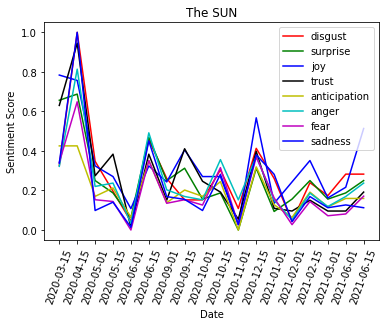

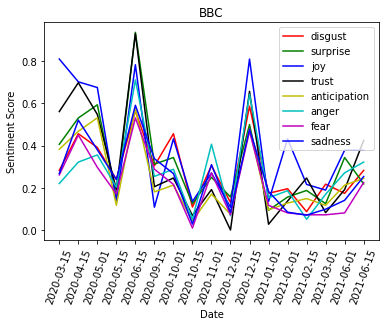

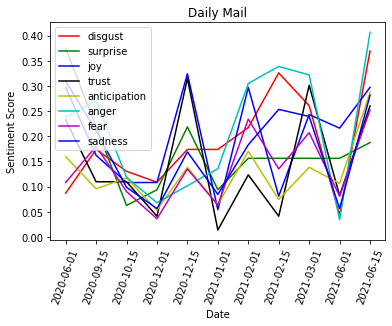

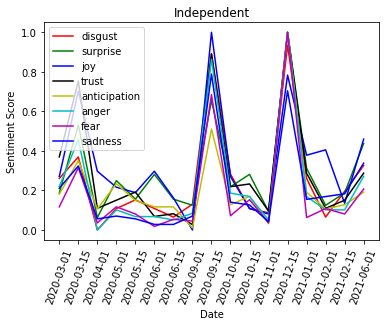

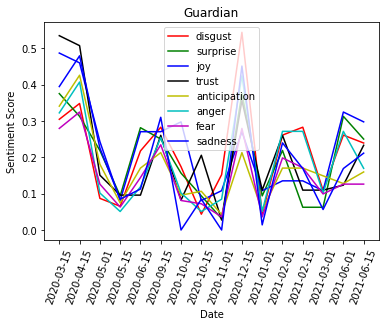

In [16]:
import numpy as np
import matplotlib.pyplot as plt 

def get_date(media_df):
    date_mk_list = media_df.select('date_mk')
    date_mk_list = [float(row['date_mk']) for row in date_mk_list.collect()]

    return date_mk_list

def get_value(media_df,Sentiment):
    Sentiment_list = media_df.select(Sentiment)
    Sentiment_list = [float(row[Sentiment]) for row in Sentiment_list.collect()]
    
    return Sentiment_list

media_list = [SUN_final,BBC_final,DailyMail_final,Independent_final,Guardian_final]
media_name = ["The SUN","BBC","Daily Mail","Independent","Guardian"]

i = 0
for media in media_list:
    
    date = [time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i))[:10] for i in get_date(media)]
    l1=plt.plot(date,get_value(media,'disgust'),'r-',label='disgust')
    l2=plt.plot(date,get_value(media,'surprise'),'g-',label='surprise')
    l3=plt.plot(date,get_value(media,'joy'),'b-',label='joy')
    l4=plt.plot(date,get_value(media,'trust'),'k-',label='trust')
    l5=plt.plot(date,get_value(media,'anticipation'),'y-',label='anticipation')
    l6=plt.plot(date,get_value(media,'anger'),'c-',label='anger')
    l7=plt.plot(date,get_value(media,'fear'),'m-',label='fear')
    l8=plt.plot(date,get_value(media,'sadness'),'b-',label='sadness')

    plt.title(media_name[i])
    i = i+1
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.xticks(rotation=70)
    plt.legend()
    plt.show()


## Vertical contrast

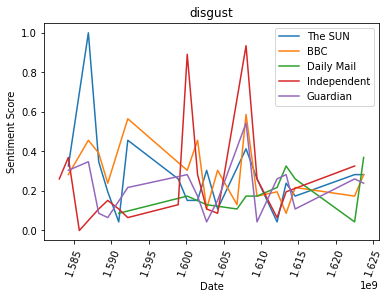

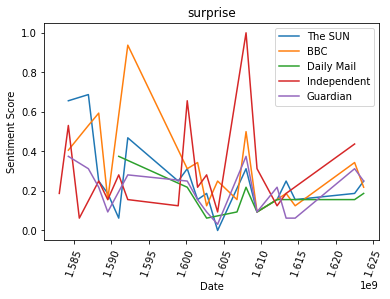

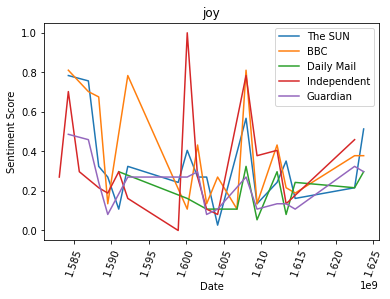

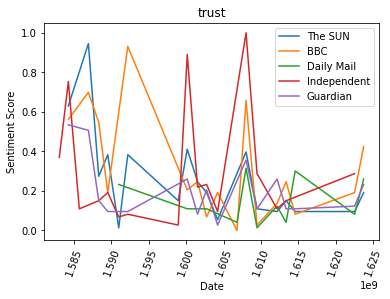

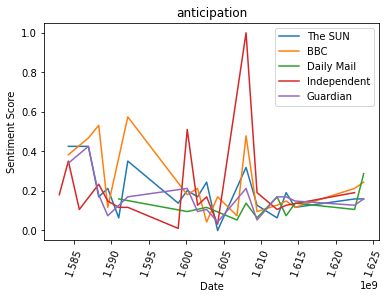

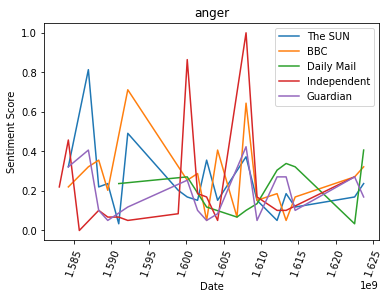

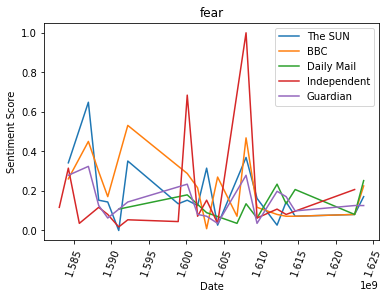

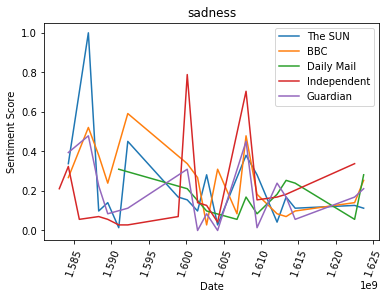

In [19]:
sentiment_list = ["disgust","surprise","joy","trust","anticipation","anger","fear","sadness"]
i = 0

def values(mask_list,value_list):
    v_list = []
    j = 0
    for i in range(len(mask_list)):
      if mask_list[i]:
        v_list.append(value_list[j])
        j = j+1
      else:
        v_list.append(None)
    return v_list

date = ['2020-03-01', '2020-03-15', 
            '2020-04-01', '2020-04-15', 
            '2020-05-01', '2020-05-15', 
            '2020-06-01', '2020-06-15', 
            '2020-09-01', '2020-09-15', 
            '2020-10-01', '2020-10-15', 
            '2020-11-01', '2020-12-01', 
            '2020-12-15', '2021-01-01', 
            '2021-02-01', '2021-02-15', 
            '2021-03-01', '2021-06-01', 
            '2021-06-15']
date_mk = [time.mktime(time.strptime(i, '%Y-%m-%d')) for i in date]

date_SUN = get_date(SUN_final)
mask_SUN = [(i in date_SUN) for i in date_mk ]
date_BBC = get_date(BBC_final)
mask_BBC = [(i in date_BBC) for i in date_mk ]
date_DailyMail = get_date(DailyMail_final)
mask_DailyMail = [(i in date_DailyMail) for i in date_mk ]
date_Independent = get_date(Independent_final)
mask_Independent = [(i in date_Independent) for i in date_mk ]
date_Guardian = get_date(Guardian_final)
mask_Guardian = [(i in date_Guardian) for i in date_mk ]

for sentiment in sentiment_list:
    
    #date = [time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i))[:10] for i in get_date(media)]

    #print(mask_SUN)
    #print(values(mask_SUN, get_value(SUN_final,sentiment)))

    l1=plt.plot(date_SUN, get_value(SUN_final,sentiment), label="The SUN")
    
    l2=plt.plot(date_BBC, get_value(BBC_final,sentiment), label="BBC")
    
    l3=plt.plot(date_DailyMail, get_value(DailyMail_final,sentiment), label="Daily Mail")
    
    l4=plt.plot(date_Independent, get_value(Independent_final,sentiment), label="Independent")
    
    l4=plt.plot(date_Guardian, get_value(Guardian_final,sentiment), label="Guardian")
    
    plt.title(sentiment)
    i = i+1
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.xticks(rotation=70)
    #plt.xticks([time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i))[:10] for i in x])
    plt.legend()
    plt.show()


## Pie

In [20]:
Pie_data = all_data
Pie_data = Pie_data.groupBy("from").agg({"anger":"sum","anticipation":"sum","disgust":"sum","fear":"sum","joy":"sum","sadness":"sum","surprise":"sum","trust":"sum"}) \
                    .withColumnRenamed("sum(anger)", "anger") \
                    .withColumnRenamed("sum(anticipation)", "anticipation") \
                    .withColumnRenamed("sum(disgust)", "disgust") \
                    .withColumnRenamed("sum(fear)", "fear") \
                    .withColumnRenamed("sum(joy)", "joy") \
                    .withColumnRenamed("sum(sadness)", "sadness") \
                    .withColumnRenamed("sum(surprise)", "surprise") \
                    .withColumnRenamed("sum(trust)", "trust")

Pie_data.show()

+-----------+-------+-----+--------+---+------------+-----+----+-------+
|       from|disgust|trust|surprise|joy|anticipation|anger|fear|sadness|
+-----------+-------+-----+--------+---+------------+-----+----+-------+
|  DailyMail|     95|  196|      60| 92|         143|  160| 213|    160|
|        SUN|    232|  478|     148|239|         351|  298| 452|    320|
|   Guardian|    157|  350|     102|152|         269|  212| 330|    245|
|        BBC|    228|  514|     174|265|         410|  310| 477|    342|
|Independent|    200|  486|     162|230|         367|  268| 422|    282|
+-----------+-------+-----+--------+---+------------+-----+----+-------+



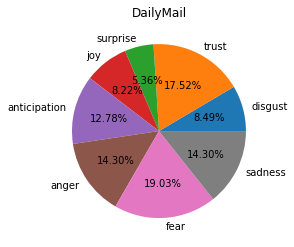

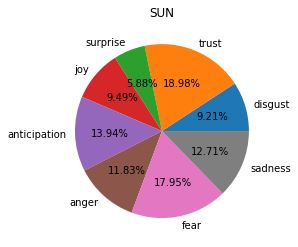

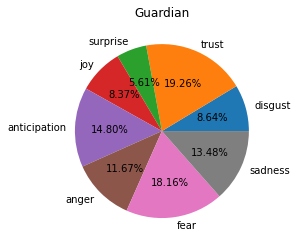

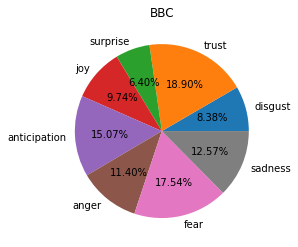

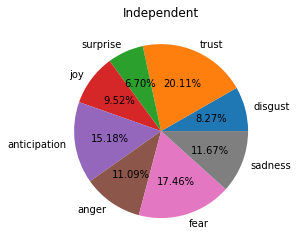

In [21]:
ax1 = plt.pie([95, 196, 60, 92, 143, 160, 213, 160],
        labels=["disgust", "trust", "surprise", "joy", "anticipation", "anger", "fear", "sadness"], 
        autopct='%.2f%%',
       )

plt.title("DailyMail") 
plt.show()

ax1 = plt.pie([232, 478, 148, 239, 351, 298, 452, 320],
        labels=["disgust", "trust", "surprise", "joy", "anticipation", "anger", "fear", "sadness"], 
        autopct='%.2f%%',
       )

plt.title("SUN") 
plt.show()

ax1 = plt.pie([157, 350, 102, 152, 269,  212, 330, 245],
        labels=["disgust", "trust", "surprise", "joy", "anticipation", "anger", "fear", "sadness"], 
        autopct='%.2f%%',
       )

plt.title("Guardian") 
plt.show()

ax1 = plt.pie([228, 514, 174, 265, 410, 310, 477, 342],
        labels=["disgust", "trust", "surprise", "joy", "anticipation", "anger", "fear", "sadness"], 
        autopct='%.2f%%',
       )

plt.title("BBC") 
plt.show()

ax1 = plt.pie([200, 486, 162,230, 367, 268, 422, 282],
        labels=["disgust", "trust", "surprise", "joy", "anticipation", "anger", "fear", "sadness"], 
        autopct='%.2f%%',
       )

plt.title("Independent") 
plt.show()